# __Appendix A__

## Assignment 6: Build and Evaluate Tree Models
Dawud Ujamaa  
School of Technology & Engineering, National University  
TIM-8555: Predictive Analysis  
Dr. Larry Fulton  
December 15, 2024 

### __2. 2.	Complete Applied Question #7 on page 364 of ISLR Python.__
In Section 8.3.3, we applied random forests to the Boston data using max_features = 6 and using n_estimators = 100 and n_estimators =500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for max_features and n_estimators. You can model your plot after Figure 8.10. Describe the results obtained.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import cross_val_score 
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC ,
DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn import metrics
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.metrics import classification_report as cr 
from sklearn.ensemble import \
(RandomForestRegressor as RF,
GradientBoostingRegressor as GBR)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
# import Boston data set
# https://islp.readthedocs.io/en/latest/datasets/Boston.html

from ISLP import load_data
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


Split data into training and test data sets with 30% of the data for the test set.

In [3]:
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train , X_test , y_train , y_test) = skm.train_test_split(X, Boston['medv'], test_size=0.3, random_state=0)

Fit random forests to the Boston data varying max_features and n_estimators

In [4]:
test_MSEs = []
for maxfeats in np.arange(1, X.shape[1]+1):
    for n_ests in np.arange(1, 100):
        RF_boston = RF(max_features=maxfeats, random_state=0, n_estimators=n_ests).fit(X_train , y_train)
        y_hat = RF_boston.predict(X_test)
        mse =  np.mean((y_test - y_hat)**2)
        test_MSEs += [[n_ests, maxfeats, mse]]

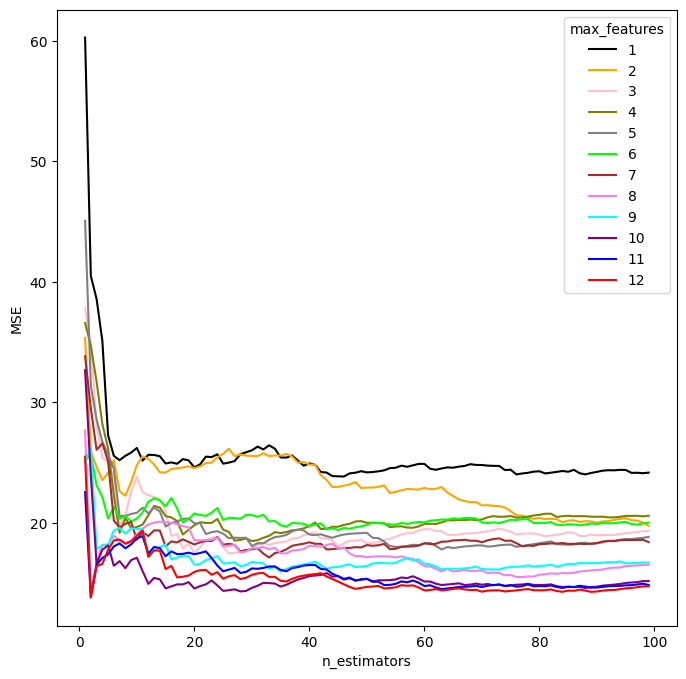

In [5]:
MSE_df = pd.DataFrame(test_MSEs, columns=['n_estimators', 'max_features', 'MSE'])

plt.figure(figsize=(8,8))
sns.lineplot(x='n_estimators', y='MSE', hue='max_features',  data=MSE_df,
            palette=['black','orange','pink','olive','gray','lime','brown','violet','cyan','purple','blue','red']);

Random Forests were applied to the Boston data varying max_features and n_estimators to obtain the test MSE.  The test data included 152 observations (30%) and the training data included 354 observations (70%).  Each data set had a total of 12 predictors.  The MSE decreases with as n_estimators increases from 1 and 40, and then MSE remains relatively constant for n_estimators > 40, for all values of max_features.  For 1 < n_estimators < 40, the model with max_features = 10 has the lowest MSE.  For values of n_estimators > 40, the model with the lowest MSE is the model with max_features = 12 (all predictors included). However, the difference in MSE between the model with max_features = 10 and max_features = 12 is not that great, and so the model with max_features = 10 performs the best across the range of tested values for n_estimators.

### __3. Compete in the Multi-class Prediction of Obesity Risk competition (late submission) on Kaggle.com__
https://www.kaggle.com/competitions/playground-series-s4e2/overview

Build four models: one decision tree, one bagged model, one random forest, and one boosted model.   

Submit them for evaluation, interpret your classification models, investigate assumptions, and interpret all findings.

#### __EDA and Preprocessing__

In [6]:
# import training data
ObeseTrainRaw = pd.read_csv(r'./train.csv',index_col=0)

# rename the variable family_history_with_overweight to shorter FHWO
ObeseTrainRaw.rename(columns={"family_history_with_overweight":"FHWO"},inplace=True)

ObeseTrainRaw

,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II


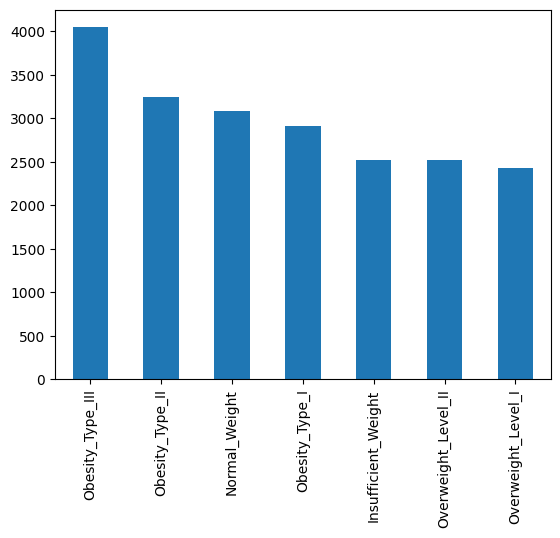

In [7]:
# plot distribution of target variable
ObeseTrainRaw['NObeyesdad'].value_counts().plot(kind='bar');

#### __Feature Engineering__
Dummy variables need to be created for the categorical variables. The variables Gender, FHWO, FAVC,  SMOKE, and SCC each have 2 levels, so only 1 dummy is needed for each variable.  CALC has 3 levels, so 2 dummies are needed, CAEC has 4 levels, so 3 dummies are needed, and MTRANS has 5 levels so 4 dummies are needed.

In [8]:
# Generate dummy variables for qualitative variables
ObeseTrainX = ObeseTrainRaw.drop(columns=['NObeyesdad'])
ObeseTrainX = pd.get_dummies(ObeseTrainX)

# drop the unneeded dummy variables 
ObeseTrainX = ObeseTrainX.drop(columns=['Gender_Female','FHWO_yes','FAVC_yes','SMOKE_yes','SCC_yes','CALC_Frequently','CAEC_Frequently','MTRANS_Public_Transportation'])
ObeseTrainX

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,FHWO_no,...,CAEC_Sometimes,CAEC_no,SMOKE_no,SCC_no,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,0,...,1,0,1,1,1,0,0,0,0,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,0,...,0,0,1,1,0,1,1,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,0,...,1,0,1,1,0,1,0,0,0,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,0,...,1,0,1,1,1,0,0,0,0,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,0,...,1,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1,0,...,1,0,1,1,1,0,0,0,0,0
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,1,1,...,0,0,1,1,1,0,0,0,0,0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1,0,...,1,0,1,1,0,1,0,0,0,0


In [9]:
# Specify dependent variable 
ObeseTrainy = ObeseTrainRaw[['NObeyesdad']]
ObeseTrainy

,NObeyesdad
id,
0,Overweight_Level_II
1,Normal_Weight
2,Insufficient_Weight
3,Obesity_Type_III
4,Overweight_Level_II
...,...
20753,Obesity_Type_II
20754,Insufficient_Weight
20755,Obesity_Type_II


#### __Split into Validation set to tune hyper parameters__
The training data is split into traning and validation sets to tune hyper parameters.

In [10]:
# make X and y for models
model = MS(ObeseTrainX, intercept=False)
D = model.fit_transform(ObeseTrainX)
feature_names = list(D.columns)
X = np.asarray(D)
y = ObeseTrainy

(X_train , X_val , y_train, y_val) = skm.train_test_split(X, y, test_size=0.3, random_state=0)

#### __Decision Tree Model__

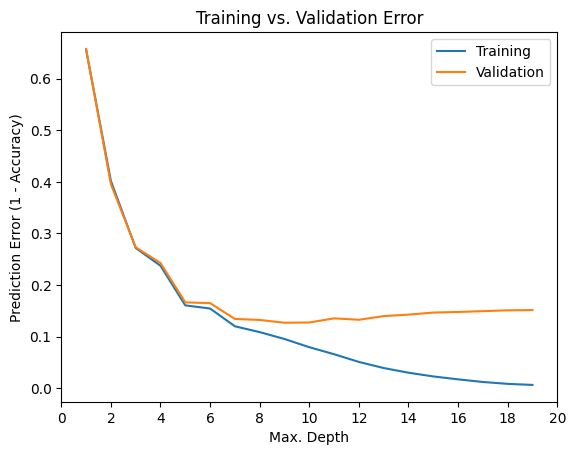

In [11]:
# look at accuracy vs max_depth on training and validation
DT_model = DTC(random_state = 0)
DT_model.fit(X_train, y_train)

def max_depth_error(max_depths):
    DT_model = DTC(max_depth=max_depths, random_state=0)
    DT_model.fit(X_train, y_train)
    training_error = 1 - DT_model.score(X_train, y_train)
    validation_error = 1 - DT_model.score(X_val, y_val)
    return {"Max Depth": max_depths, "Training error": training_error, "Validation Error": validation_error}

max_depth_Df = pd.DataFrame([max_depth_error(md) for md in range(1, 20)])

# plot accuracy vs max_depth
plt.figure()
plt.plot(max_depth_Df['Max Depth'], max_depth_Df['Training error'])
plt.plot(max_depth_Df['Max Depth'], max_depth_Df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

The plot shows that max_depth=5 is the point where the training and validation accuracy are closest. 

In [12]:
# use gridsearchcv

# Define the model
DT_model = DTC(random_state = 0)

# Define the set of Hyperparameter
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'criterion':  ['gini', 'entropy']
}

# Running the GridSearchCV
grid_search = GridSearchCV(estimator=DT_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5}
Best Score: 0.8385681723975791


In [13]:
# Initialize the model
DT_model = DTC(criterion='gini', max_depth=5, random_state=0)

# evaluate the model and collect the scores
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(DT_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the model
DT_model = DT_model.fit(X, y)
print( DT_model.score(X,y))

y_pred_DT=DT_model.predict(X)
print(cr(y,y_pred_DT))

Mean Accuracy: 0.836 (0.009)
0.8382792176510261
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.92      0.90      2523
      Normal_Weight       0.83      0.64      0.72      3082
     Obesity_Type_I       0.86      0.78      0.82      2910
    Obesity_Type_II       0.96      0.95      0.96      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.57      0.81      0.66      2427
Overweight_Level_II       0.73      0.69      0.71      2522

           accuracy                           0.84     20758
          macro avg       0.83      0.83      0.83     20758
       weighted avg       0.85      0.84      0.84     20758



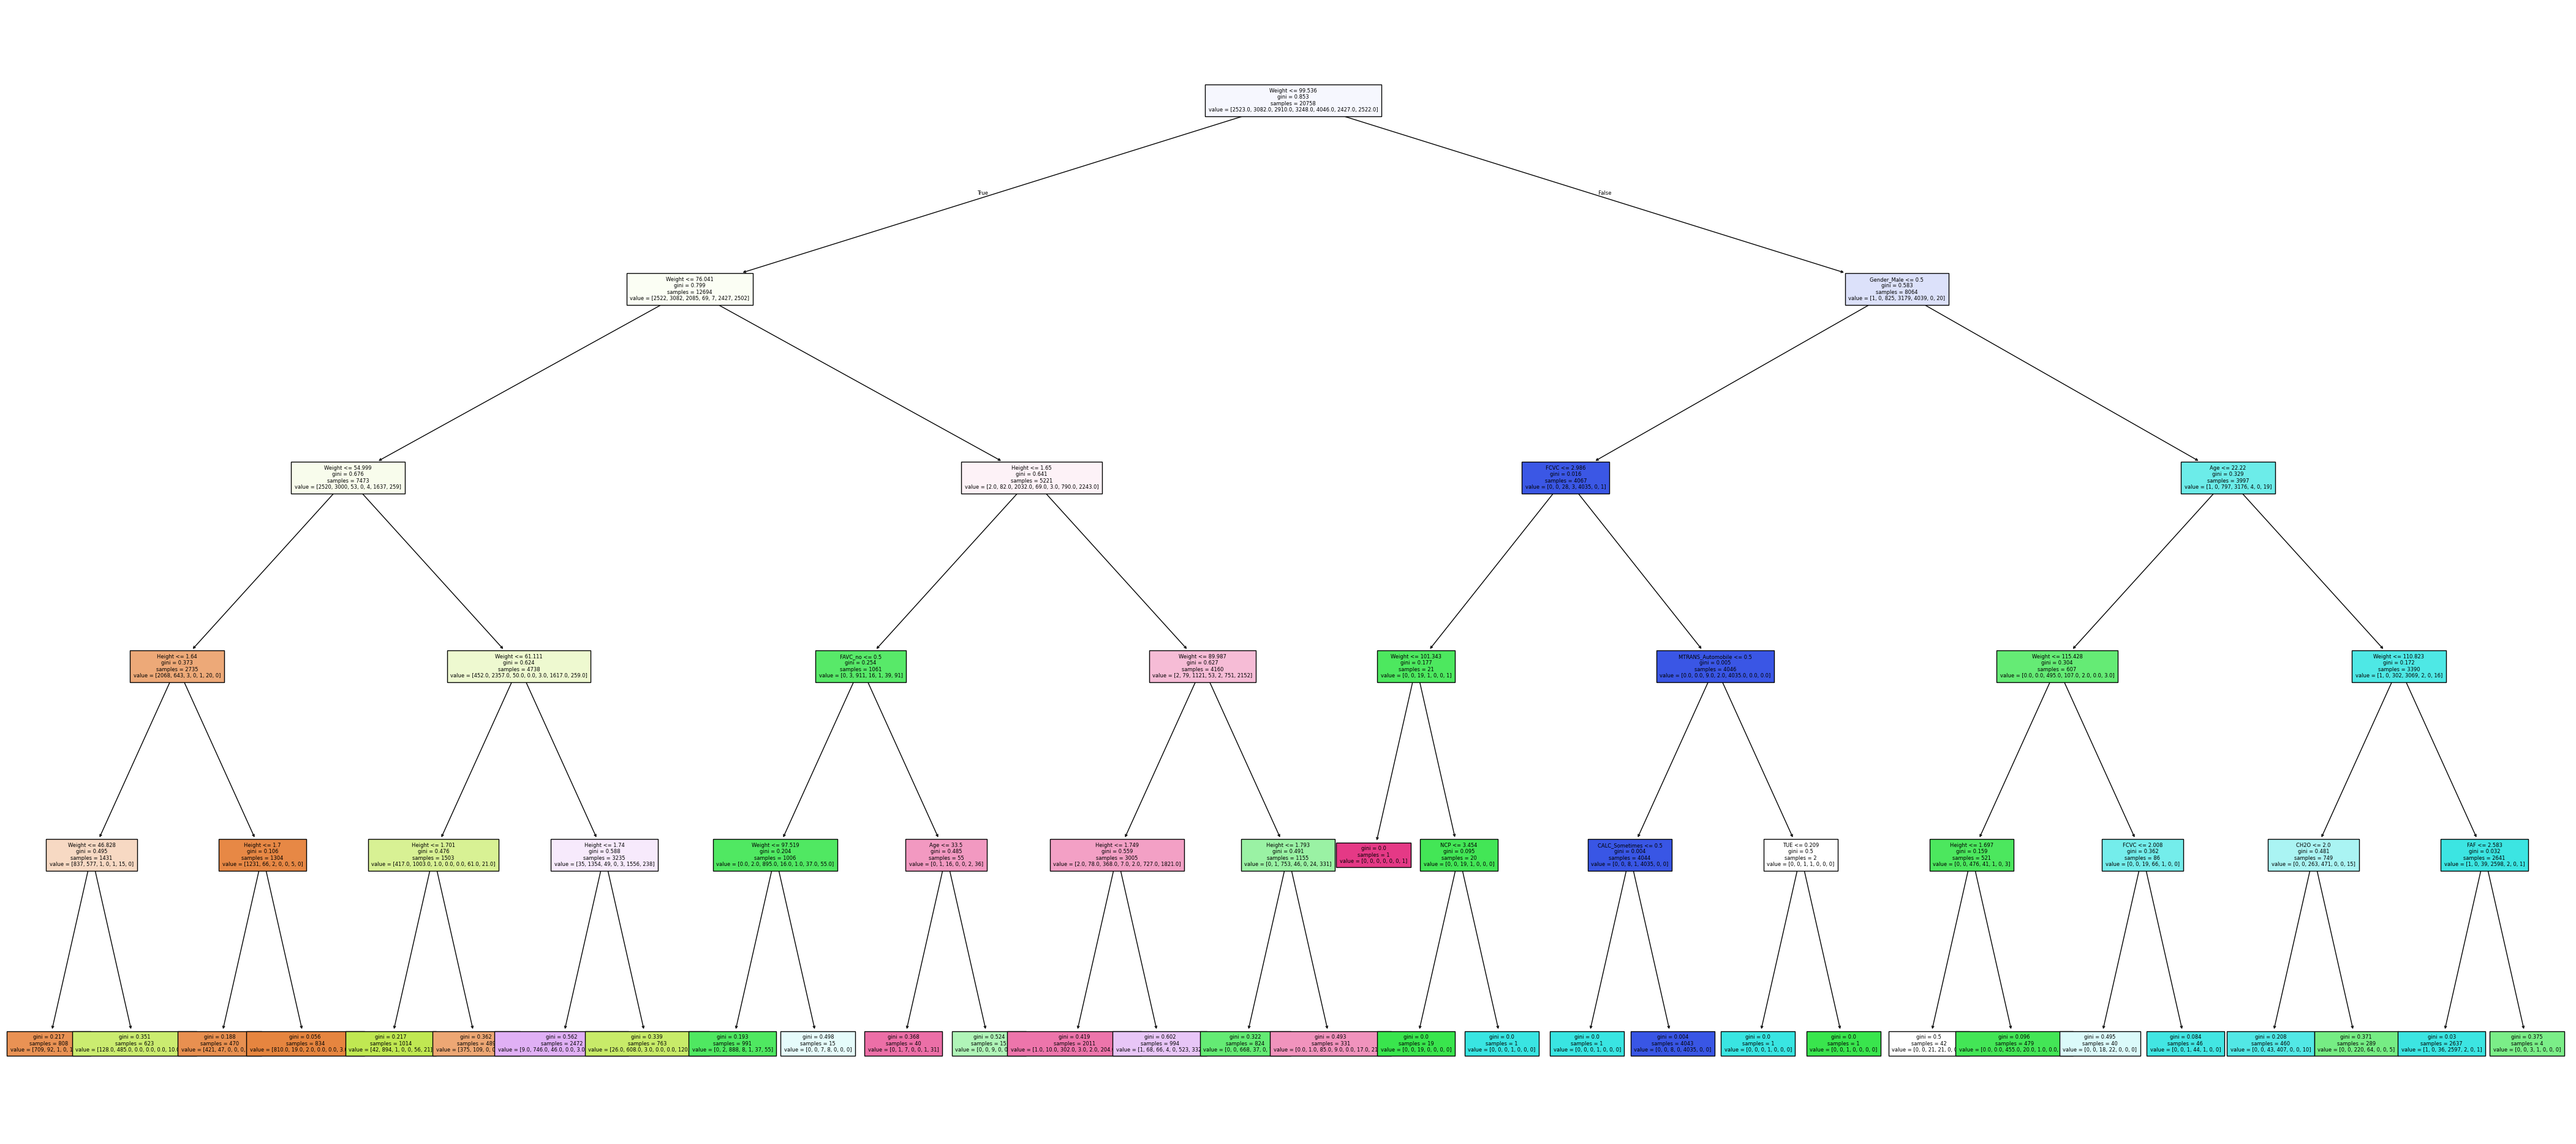

In [14]:
# plot the decision tree
plt.figure(figsize=[54, 24])
p = plot_tree(DT_model, feature_names=D.columns, filled=True, fontsize=6);

In [15]:
print(export_text(DT_model, feature_names=D.columns, show_weights=True))

|--- Weight <= 99.54
|   |--- Weight <= 76.04
|   |   |--- Weight <= 55.00
|   |   |   |--- Height <= 1.64
|   |   |   |   |--- Weight <= 46.83
|   |   |   |   |   |--- weights: [709.00, 92.00, 1.00, 0.00, 1.00, 5.00, 0.00] class: Insufficient_Weight
|   |   |   |   |--- Weight >  46.83
|   |   |   |   |   |--- weights: [128.00, 485.00, 0.00, 0.00, 0.00, 10.00, 0.00] class: Normal_Weight
|   |   |   |--- Height >  1.64
|   |   |   |   |--- Height <= 1.70
|   |   |   |   |   |--- weights: [421.00, 47.00, 0.00, 0.00, 0.00, 2.00, 0.00] class: Insufficient_Weight
|   |   |   |   |--- Height >  1.70
|   |   |   |   |   |--- weights: [810.00, 19.00, 2.00, 0.00, 0.00, 3.00, 0.00] class: Insufficient_Weight
|   |   |--- Weight >  55.00
|   |   |   |--- Weight <= 61.11
|   |   |   |   |--- Height <= 1.70
|   |   |   |   |   |--- weights: [42.00, 894.00, 1.00, 0.00, 0.00, 56.00, 21.00] class: Normal_Weight
|   |   |   |   |--- Height >  1.70
|   |   |   |   |   |--- weights: [375.00, 109.00, 0.0

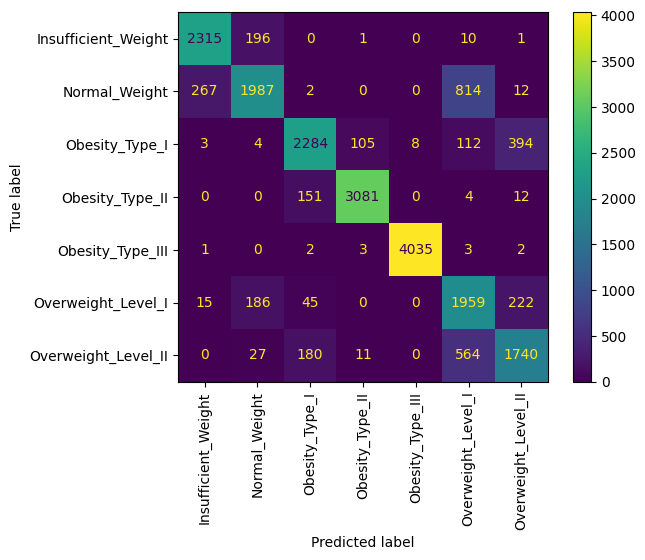

In [16]:
# Confusion matrix
metrics.confusion_matrix(y, y_pred_DT)
metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred_DT)
plt.xticks(rotation=90)
plt.show();

#### __Bagged Model__

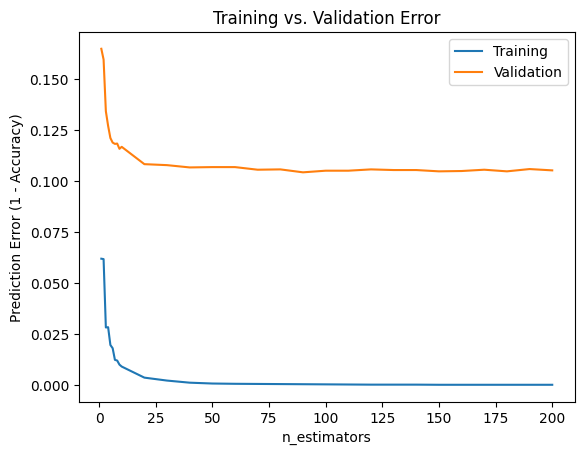

In [17]:
# look at accuracy vs n_estimators on training and validation
BAG_model = RandomForestClassifier(max_features=X.shape[1], random_state=0)
BAG_model.fit(X_train, y_train)

def n_estimators_error(num_estimators):
    BAG_model = RandomForestClassifier(n_estimators=num_estimators, max_features=X.shape[1], random_state=0)
    BAG_model.fit(X_train, y_train)
    training_error = 1 - BAG_model.score(X_train, y_train)
    validation_error = 1 - BAG_model.score(X_val, y_val)
    return {"n_estimators": num_estimators, "Training error": training_error, "Validation Error": validation_error}

#n_estimators_Df = pd.DataFrame([n_estimators_error(num_est) for num_est in ([(10*x)+10 for x in range(20)])])
list=[1,2,3,4,5,6,7,8,9,10,20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
n_estimators_Df = pd.DataFrame([n_estimators_error(num_est) for num_est in list])

# plot accuracy vs n_estimators
plt.figure()
plt.plot(n_estimators_Df['n_estimators'], n_estimators_Df['Training error'])
plt.plot(n_estimators_Df['n_estimators'], n_estimators_Df['Validation Error'])
plt.title('Training vs. Validation Error')
#plt.xticks(range(0,21, 2))
plt.xlabel('n_estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

In [18]:
# use gridsearchcv

# Define the model
BAG_model = RandomForestClassifier(max_features=X.shape[1], random_state=0)

# Define the set of Hyperparameter
param_grid = {
    'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Running the GridSearchCV
grid_search = GridSearchCV(estimator=BAG_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'n_estimators': 70}
Best Score: 0.8920417881059374


GridSearchCV recommends using `n_estimators=70` for the Bagged model. The Bagged Model with be fit to the full training data set using `n_estimators=70` and evaluated.

In [19]:
# Initialize the model
BAG_model = RandomForestClassifier(max_features=X.shape[1], random_state=0, n_estimators=70)

# evaluate the model and collect the scores
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(BAG_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the model
BAG_model = BAG_model.fit(X, y)
print( BAG_model.score(X,y))

y_pred_BM=BAG_model.predict(X)
print(cr(y,y_pred_BM, digits=4))

Mean Accuracy: 0.892 (0.007)
0.999759129010502
                     precision    recall  f1-score   support

Insufficient_Weight     0.9992    1.0000    0.9996      2523
      Normal_Weight     0.9997    0.9994    0.9995      3082
     Obesity_Type_I     0.9997    0.9997    0.9997      2910
    Obesity_Type_II     0.9997    0.9997    0.9997      3248
   Obesity_Type_III     1.0000    1.0000    1.0000      4046
 Overweight_Level_I     1.0000    0.9996    0.9998      2427
Overweight_Level_II     1.0000    1.0000    1.0000      2522

           accuracy                         0.9998     20758
          macro avg     0.9997    0.9998    0.9998     20758
       weighted avg     0.9998    0.9998    0.9998     20758



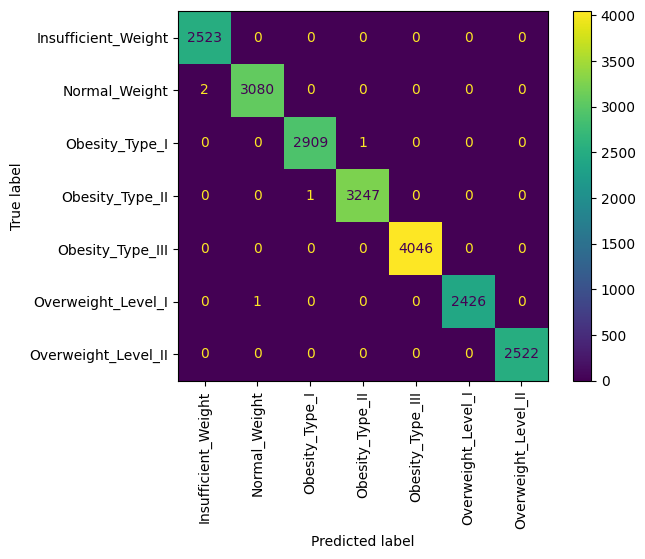

In [20]:
# Confusion matrix
metrics.confusion_matrix(y, y_pred_BM)
metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred_BM)
plt.xticks(rotation=90)
plt.show();

#### __Random Forest__
Use GridSearchCV to find the best values to use for the parameters `max_features`, `n_estimators`, and `max_depth`

In [21]:
# use gridsearchcv

# Define the model
RFC_model = RandomForestClassifier(random_state=0)

# Define the set of Hyperparameter
param_grid = {
    'max_depth': [1,5,10],
    'max_features': [1, 11, 22],
    'n_estimators': [100, 200]        
}

# Running the GridSearchCV
grid_search = GridSearchCV(estimator=RFC_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 10, 'max_features': 11, 'n_estimators': 200}
Best Score: 0.899605069976406


GridSearchCV recommends using `n_estimators=200`, `max_depth=10`, and `max_features=11` for the Random Forest model. The Random Forest Model wiii be fit to the full training data set using all of the above hyper parameters except `max_depth` will be set at 5 to prevent overfitting.

In [22]:
# Initialize the model
RFC_model = RandomForestClassifier(max_depth=5, max_features=11, n_estimators=200, random_state=0)

# evaluate the model and collect the scores
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(RFC_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the model
RFC_model = RFC_model.fit(X, y)
print( RFC_model.score(X,y))

y_pred_RFC=RFC_model.predict(X)
print(cr(y,y_pred_RFC))

Mean Accuracy: 0.853 (0.005)
0.8564890644570768
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.93      0.90      2523
      Normal_Weight       0.77      0.84      0.80      3082
     Obesity_Type_I       0.87      0.83      0.85      2910
    Obesity_Type_II       0.96      0.97      0.96      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.83      0.50      0.63      2427
Overweight_Level_II       0.65      0.80      0.72      2522

           accuracy                           0.86     20758
          macro avg       0.85      0.84      0.84     20758
       weighted avg       0.86      0.86      0.85     20758



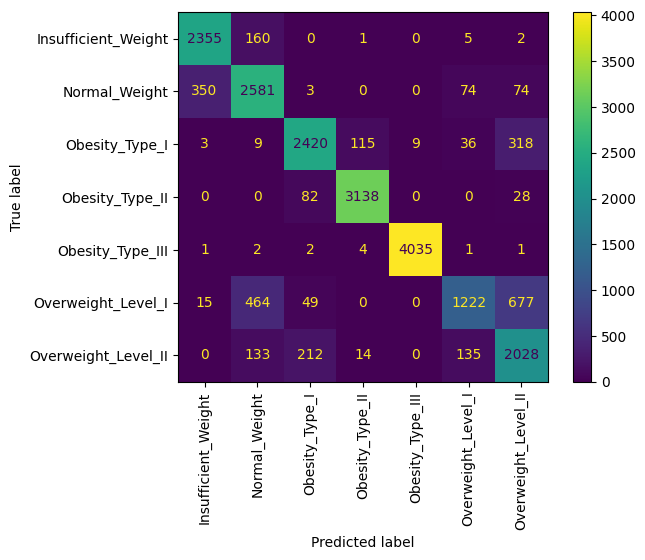

In [23]:
# Confusion matrix
metrics.confusion_matrix(y, y_pred_RFC)
metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred_RFC)
plt.xticks(rotation=90)
plt.show();

In [24]:
# Get feature importance
importance = pd.DataFrame(
    data={
        'feature': D.columns,
        'importance': RFC_model.feature_importances_,
    }
).sort_values('importance', ascending=False)

importance

,feature,importance
2,Weight,0.539488
8,Gender_Male,0.143644
3,FCVC,0.107612
0,Age,0.067758
1,Height,0.065127
9,FHWO_no,0.019108
7,TUE,0.017455
5,CH2O,0.011410
4,NCP,0.008411
12,CAEC_Sometimes,0.006104


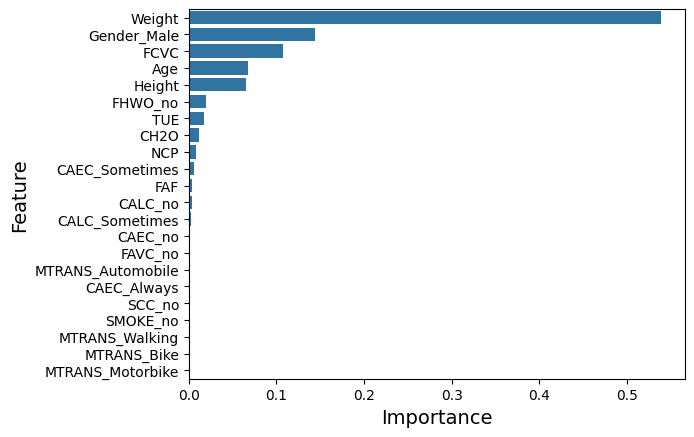

In [25]:
# Plot feature importance
p = sns.barplot(data=importance, y='feature', x='importance')
p.set_xlabel('Importance', fontsize=14)
p.set_ylabel('Feature', fontsize=14)
plt.show();

#### __Boosted Model__
Use GridSearchCV to find the best values to use for the parameters `n_estimators`, and `max_depth`

In [26]:
# use gridsearchcv

# Define the model
GBC_model = GBC(learning_rate =0.001, random_state=0)

# Define the set of Hyperparameter
param_grid = {
    'max_depth': [2, 3, 5],
    'n_estimators': [100, 200]        
}

# Running the GridSearchCV
grid_search = GridSearchCV(estimator=GBC_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 200}
Best Score: 0.8463724296998331


GridSearchCV recommends using `n_estimators=200` and `max_depth=10` for the Boosted model. The Boosted Model wiii be fit to the full training data set using the above hyper parameters.

In [27]:
# Initialize the model
GBC_model = GBC(max_depth=5, n_estimators=200, learning_rate =0.001, random_state=0)

# evaluate the model and collect the scores
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(GBC_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the model
GBC_model = GBC_model.fit(X, y)
print( GBC_model.score(X,y))

y_pred_GBC=GBC_model.predict(X)
print(cr(y,y_pred_GBC))

Mean Accuracy: 0.846 (0.007)
0.8536467867810001
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.89      0.91      2523
      Normal_Weight       0.75      0.91      0.82      3082
     Obesity_Type_I       0.81      0.82      0.81      2910
    Obesity_Type_II       0.96      0.97      0.96      3248
   Obesity_Type_III       0.95      1.00      0.98      4046
 Overweight_Level_I       0.77      0.58      0.66      2427
Overweight_Level_II       0.73      0.67      0.70      2522

           accuracy                           0.85     20758
          macro avg       0.84      0.83      0.84     20758
       weighted avg       0.85      0.85      0.85     20758



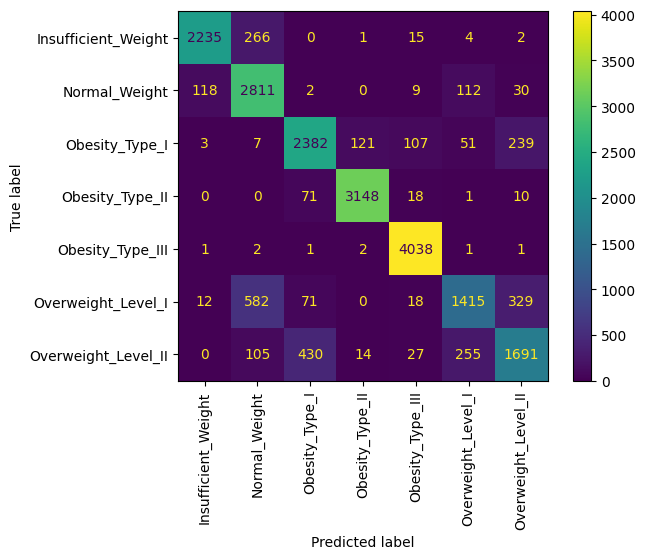

In [28]:
# Confusion matrix
metrics.confusion_matrix(y, y_pred_GBC)
metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred_GBC)
plt.xticks(rotation=90)
plt.show();

In [29]:
# Get feature importance
importance = pd.DataFrame(
    data={
        'feature': D.columns,
        'importance': GBC_model.feature_importances_,
    }
).sort_values('importance', ascending=False)

importance

,feature,importance
2,Weight,0.620551
3,FCVC,0.128011
1,Height,0.096167
8,Gender_Male,0.091145
5,CH2O,0.019753
4,NCP,0.016333
0,Age,0.015348
17,CALC_no,0.004421
10,FAVC_no,0.003584
6,FAF,0.001956


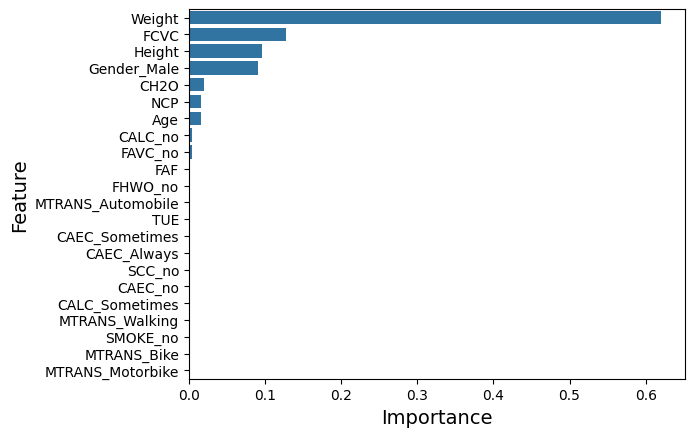

In [30]:
# Plot feature importance
p = sns.barplot(data=importance, y='feature', x='importance')
p.set_xlabel('Importance', fontsize=14)
p.set_ylabel('Feature', fontsize=14)
plt.show();

#### __Generate predictions on the test data__

##### __Test data preprocessing and feature engineering__

In [31]:
# import test data
ObeseTest = pd.read_csv(r'./test.csv',index_col=0)

# rename the variable family_history_with_overweight to shorter FHWO
ObeseTest.rename(columns={"family_history_with_overweight":"FHWO"},inplace=True)

# Generate dummy variables for qualitative variables
ObeseTestX = pd.get_dummies(ObeseTest)

# drop the unneeded dummy variables 
ObeseTestX = ObeseTestX.drop(columns=['Gender_Female','FHWO_yes','FAVC_yes','SMOKE_yes','SCC_yes','CALC_Frequently',
                                      'CAEC_Frequently','CALC_Always','MTRANS_Public_Transportation'])
ObeseTestX

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,FHWO_no,...,CAEC_Sometimes,CAEC_no,SMOKE_no,SCC_no,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,
20758,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,1,0,...,1,0,1,1,1,0,0,0,0,0
20759,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,0,0,...,1,0,1,1,1,0,0,0,0,0
20760,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,0,0,...,1,0,1,1,1,0,0,0,0,0
20761,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,1,0,...,1,0,1,1,1,0,0,0,0,0
20762,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,0,0,...,1,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,23.327836,1.721384,78.030383,2.813234,3.000000,1.000000,0.807076,0.778632,1,0,...,1,0,1,1,1,0,0,0,0,0
34594,29.000000,1.590000,62.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0,1,...,1,0,1,1,1,0,0,0,0,0
34595,22.935612,1.585547,44.376637,3.000000,2.273740,2.000000,1.949840,1.000000,0,1,...,0,0,1,1,1,0,0,0,0,0


In [32]:
# make X_test for predictions
#model = MS(ObeseTestX, intercept=False)
#D = model.fit_transform(ObeseTestX)
#feature_names = D.columns
#X_test = np.asarray(D)

##### __Decision Tree Model predictions on Test__

In [33]:
y_DTCpred=DT_model.predict(ObeseTestX)
DTC_Submission = pd.DataFrame( y_DTCpred , columns=['NObeyesdad'], index = ObeseTestX.index)
DTC_Submission.to_csv(r'DTC_ObesitySubmission.csv', index = True)
DTC_Submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Overweight_Level_I
34595,Insufficient_Weight


##### __Bagged Model predictions on Test__

In [34]:
y_BAGpred=BAG_model.predict(ObeseTestX)
BAG_Submission = pd.DataFrame( y_BAGpred , columns=['NObeyesdad'], index = ObeseTestX.index)
BAG_Submission.to_csv(r'BAG_ObesitySubmission.csv', index = True)
BAG_Submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Overweight_Level_I
34595,Insufficient_Weight


##### __Random Forest predictions on Test__

In [35]:
y_RFCpred=RFC_model.predict(ObeseTestX)
RFC_Submission = pd.DataFrame( y_RFCpred , columns=['NObeyesdad'], index = ObeseTestX.index)
RFC_Submission.to_csv(r'RFC_ObesitySubmission.csv', index = True)
RFC_Submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Normal_Weight
34595,Insufficient_Weight


##### __Boosted Model predictions on Test__

In [36]:
y_GBCpred=GBC_model.predict(ObeseTestX)
GBC_Submission = pd.DataFrame( y_GBCpred , columns=['NObeyesdad'], index = ObeseTestX.index)
GBC_Submission.to_csv(r'GBC_ObesitySubmission.csv', index = True)
GBC_Submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Normal_Weight
34595,Insufficient_Weight


In [37]:
# Print Python version
import sys
print(sys.version)

# Print Jupyter notebook version
import notebook
notebook.__version__

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


'7.2.2'

In [38]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.29.0
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2
jupyterlab       : 4.2.6
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.2
qtconsole        : not installed
traitlets        : 5.14.3
